# Project: Detecting Autism with Deep Learning

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import random
import os
import shutil
import glob
import re

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow
import keras
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D

# Importing Data

In [23]:
data = 'AutismDataset'
autistic = 'AutismDataset/train/Autistic'
non_autistic= 'AutismDataset/train/Non_Autistic'

dirlist=[autistic, non_autistic]
classes=['yes', 'no']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)  
        
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
train_df=pd.concat([Files,Label], axis=1)
train_df['labels']=pd.get_dummies(train_df['labels'])

train_df.head()

,filepaths,labels
0,drive/MyDrive/AutismDataset/train/Autistic/000...,0
1,drive/MyDrive/AutismDataset/train/Autistic/000...,0
2,drive/MyDrive/AutismDataset/train/Autistic/000...,0
3,drive/MyDrive/AutismDataset/train/Autistic/000...,0
4,drive/MyDrive/AutismDataset/train/Autistic/000...,0


In [24]:
from sklearn.utils import shuffle
train_df = shuffle(train_df)
train_df.head()

,filepaths,labels
342,drive/MyDrive/AutismDataset/train/Autistic/034...,0
893,drive/MyDrive/AutismDataset/train/Non_Autistic...,1
262,drive/MyDrive/AutismDataset/train/Autistic/026...,0
439,drive/MyDrive/AutismDataset/train/Autistic/044...,0
1126,drive/MyDrive/AutismDataset/train/Non_Autistic...,1


In [25]:
print('the shape of train data =', train_df.shape)

the shape of train data = (1400, 2)


In [26]:
data = 'AutismDataset'
autistic = 'AutismDataset/test/Autistic'
non_autistic= 'AutismDataset/test/Non_Autistic'

dirlist=[autistic, non_autistic]
classes=['yes', 'no']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)  
        
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
test_df=pd.concat([Files,Label], axis=1)
test_df['labels']=pd.get_dummies(test_df['labels'])

test_df.head()

,filepaths,labels
0,drive/MyDrive/AutismDataset/test/Autistic/01.jpg,0
1,drive/MyDrive/AutismDataset/test/Autistic/13.jpg,0
2,drive/MyDrive/AutismDataset/test/Autistic/16.jpg,0
3,drive/MyDrive/AutismDataset/test/Autistic/12.jpg,0
4,drive/MyDrive/AutismDataset/test/Autistic/18.jpg,0


In [27]:
test_df = shuffle(test_df)
test_df.head()

,filepaths,labels
31,drive/MyDrive/AutismDataset/test/Autistic/30.jpg,0
9,drive/MyDrive/AutismDataset/test/Autistic/10.jpg,0
13,drive/MyDrive/AutismDataset/test/Autistic/08.jpg,0
22,drive/MyDrive/AutismDataset/test/Autistic/24.jpg,0
63,drive/MyDrive/AutismDataset/test/Non_Autistic/...,1


In [28]:
print('the shape of test data =', test_df.shape)

the shape of test data = (100, 2)


# Pre-processing Data

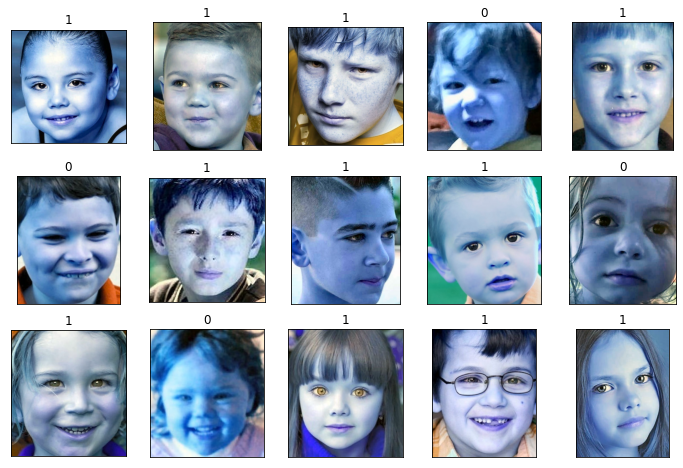

In [29]:
import cv2
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(train_df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(train_df.loc[random,"filepaths"]))
    plt.title(train_df.loc[random, "labels"]) 
    plt.xticks([])
    plt.yticks([])
plt.show()

In [30]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

train_img = []
train_labels = []

for idx, row in train_df.iterrows():
    path = row['filepaths']
    austic = row['labels']
    image = load_img(path,target_size=(224,224))
    image_array = img_to_array(image)   
    train_img.append(image_array)
    train_labels.append(austic)
    x_train = train_img
    y_train = np.array(train_labels)
    
test_img = []
test_labels = []

for idx, row in test_df.iterrows():
    path = row['filepaths']
    austic = row['labels']
    image = load_img(path,target_size=(224,224))
    image_array = img_to_array(image)   
    test_img.append(image_array)
    test_labels.append(austic)
    x_test = test_img
    y_test = np.array(test_labels)

In [33]:
print('the shape of x train =', x_train.shape)
print('the shape of y train =', y_train.shape)
print('\n')
print('the shape of x test =', x_test.shape)
print('the shape of y test =', y_test.shape)

the shape of x train = (1400, 224, 224, 3)
the shape of y train = (1400,)


the shape of x test = (100, 224, 224, 3)
the shape of y test = (100,)


In [32]:
x_train = x_train/ 255
x_test = x_test/ 255

In [34]:
datagen = ImageDataGenerator(featurewise_center=False,samplewise_center=False,
                             featurewise_std_normalization=False,samplewise_std_normalization=False,
                             zca_whitening=False,rotation_range = 40,zoom_range = 0.3,
                             width_shift_range=0.25,height_shift_range=0.25,
                             horizontal_flip = True,vertical_flip=False)
datagen.fit(x_train)

# Modelling

## Model 1: 3 Layer CNN with MaxPooling

In [35]:
input_shape = (224,224,3)

In [49]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=tensorflow.keras.optimizers.Adam(),metrics=['acc'])

In [50]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization_11 (Bat  (None, 111, 111, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                      

In [51]:
history = model.fit(x_train, y_train, batch_size=10, epochs=10, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
140/140 [==============================] - 10s 60ms/step - loss: 0.9368 - acc: 0.5843 - val_loss: 0.9137 - val_acc: 0.5100
Epoch 2/10
140/140 [==============================] - 8s 56ms/step - loss: 0.7152 - acc: 0.6550 - val_loss: 0.9252 - val_acc: 0.5100
Epoch 3/10
140/140 [==============================] - 8s 58ms/step - loss: 0.6142 - acc: 0.6900 - val_loss: 0.7990 - val_acc: 0.6000
Epoch 4/10
140/140 [==============================] - 8s 57ms/step - loss: 0.5671 - acc: 0.7271 - val_loss: 0.6856 - val_acc: 0.5900
Epoch 5/10
140/140 [==============================] - 8s 58ms/step - loss: 0.5054 - acc: 0.7664 - val_loss: 0.9534 - val_acc: 0.5500
Epoch 6/10
140/140 [==============================] - 8s 57ms/step - loss: 0.4856 - acc: 0.7743 - val_loss: 0.9798 - val_acc: 0.5900
Epoch 7/10
140/140 [==============================] - 8s 58ms/step - loss: 0.4400 - acc: 0.7971 - val_loss: 1.0941 - val_acc: 0.5400
Epoch 8/10
140/140 [==============================] - 8s 57ms/step -

In [52]:
acc = history.history['acc']
val_acc =history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

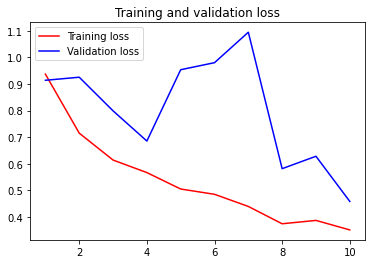

In [53]:
plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
plt.show()

## Model 2: 3 Layer CNN with Average Pooling

In [54]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=tensorflow.keras.optimizers.Adam(),metrics=['acc'])

In [55]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 average_pooling2d (AverageP  (None, 111, 111, 64)     0         
 ooling2D)                                                       
                                                                 
 batch_normalization_15 (Bat  (None, 111, 111, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 average_pooling2d_1 (Averag  (None, 54, 54, 64)       0         
 ePooling2D)                                                     
                                                      

In [56]:
history = model.fit(x_train, y_train, batch_size=10, epochs=10, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
140/140 [==============================] - 9s 58ms/step - loss: 0.9020 - acc: 0.5957 - val_loss: 1.4644 - val_acc: 0.5000
Epoch 2/10
140/140 [==============================] - 8s 55ms/step - loss: 0.6769 - acc: 0.6707 - val_loss: 0.7707 - val_acc: 0.4900
Epoch 3/10
140/140 [==============================] - 8s 55ms/step - loss: 0.6900 - acc: 0.6529 - val_loss: 0.9608 - val_acc: 0.5800
Epoch 4/10
140/140 [==============================] - 8s 55ms/step - loss: 0.6270 - acc: 0.6871 - val_loss: 0.6114 - val_acc: 0.6800
Epoch 5/10
140/140 [==============================] - 8s 55ms/step - loss: 0.5681 - acc: 0.7136 - val_loss: 0.5078 - val_acc: 0.7800
Epoch 6/10
140/140 [==============================] - 8s 56ms/step - loss: 0.5582 - acc: 0.7286 - val_loss: 0.6324 - val_acc: 0.6900
Epoch 7/10
140/140 [==============================] - 8s 57ms/step - loss: 0.4936 - acc: 0.7743 - val_loss: 0.5104 - val_acc: 0.7500
Epoch 8/10
140/140 [==============================] - 8s 55ms/step - 

In [57]:
acc = history.history['acc']
val_acc =history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

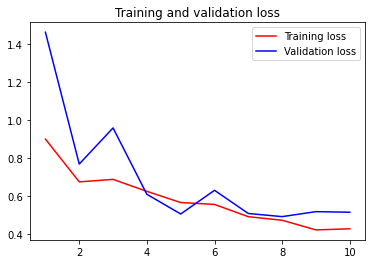

In [58]:
plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
plt.show()

## Model 3: 5 Layer CNN with MaxPooling

In [60]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=tensorflow.keras.optimizers.Adam(),metrics=['acc'])

In [61]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_19 (Bat  (None, 111, 111, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                      

In [62]:
history = model.fit(x_train, y_train, batch_size=10, epochs=10, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
140/140 [==============================] - 10s 60ms/step - loss: 0.8840 - acc: 0.5686 - val_loss: 0.6870 - val_acc: 0.5500
Epoch 2/10
140/140 [==============================] - 8s 59ms/step - loss: 0.6804 - acc: 0.6571 - val_loss: 1.0046 - val_acc: 0.5000
Epoch 3/10
140/140 [==============================] - 8s 58ms/step - loss: 0.6533 - acc: 0.6693 - val_loss: 0.5978 - val_acc: 0.6500
Epoch 4/10
140/140 [==============================] - 8s 59ms/step - loss: 0.5907 - acc: 0.7057 - val_loss: 0.5428 - val_acc: 0.7500
Epoch 5/10
140/140 [==============================] - 8s 58ms/step - loss: 0.5640 - acc: 0.7407 - val_loss: 0.6347 - val_acc: 0.6900
Epoch 6/10
140/140 [==============================] - 8s 59ms/step - loss: 0.5033 - acc: 0.7500 - val_loss: 0.7211 - val_acc: 0.6700
Epoch 7/10
140/140 [==============================] - 8s 58ms/step - loss: 0.4872 - acc: 0.7650 - val_loss: 0.7014 - val_acc: 0.6600
Epoch 8/10
140/140 [==============================] - 8s 58ms/step -

In [63]:
acc = history.history['acc']
val_acc =history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

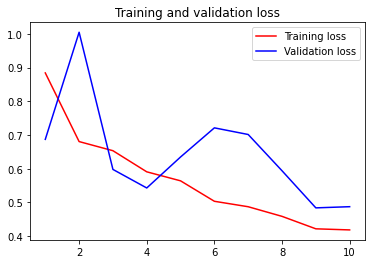

In [64]:
plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
plt.show()

## Model 4: 5 Layer CNN with Average Pooling

In [65]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=tensorflow.keras.optimizers.Adam(),metrics=['acc'])

In [66]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 average_pooling2d_3 (Averag  (None, 111, 111, 64)     0         
 ePooling2D)                                                     
                                                                 
 batch_normalization_25 (Bat  (None, 111, 111, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 average_pooling2d_4 (Averag  (None, 54, 54, 64)       0         
 ePooling2D)                                                     
                                                      

In [67]:
history = model.fit(x_train, y_train, batch_size=10, epochs=10, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
140/140 [==============================] - 10s 60ms/step - loss: 0.9128 - acc: 0.5657 - val_loss: 1.3826 - val_acc: 0.5000
Epoch 2/10
140/140 [==============================] - 8s 57ms/step - loss: 0.7348 - acc: 0.6357 - val_loss: 0.6312 - val_acc: 0.6000
Epoch 3/10
140/140 [==============================] - 8s 57ms/step - loss: 0.7296 - acc: 0.6200 - val_loss: 0.6003 - val_acc: 0.6800
Epoch 4/10
140/140 [==============================] - 8s 58ms/step - loss: 0.6778 - acc: 0.6514 - val_loss: 0.6641 - val_acc: 0.5800
Epoch 5/10
140/140 [==============================] - 8s 56ms/step - loss: 0.6537 - acc: 0.6429 - val_loss: 0.6381 - val_acc: 0.7000
Epoch 6/10
140/140 [==============================] - 8s 56ms/step - loss: 0.5935 - acc: 0.6893 - val_loss: 0.5852 - val_acc: 0.7300
Epoch 7/10
140/140 [==============================] - 8s 56ms/step - loss: 0.5620 - acc: 0.7093 - val_loss: 0.5575 - val_acc: 0.7200
Epoch 8/10
140/140 [==============================] - 8s 56ms/step -

In [68]:
acc = history.history['acc']
val_acc =history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

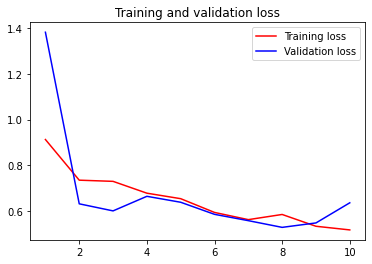

In [69]:
plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
plt.show()

## Model 5: 7 Layer CNN with MaxPooling

In [72]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=tensorflow.keras.optimizers.Adam(),metrics=['acc'])

In [73]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization_39 (Bat  (None, 222, 222, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 batch_normalization_40 (Bat  (None, 220, 220, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_34 (Conv2D)          (None, 218, 218, 64)      36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 109, 109, 64)    

In [74]:
history = model.fit(x_train, y_train, batch_size=10, epochs=10, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
140/140 [==============================] - 35s 219ms/step - loss: 0.8303 - acc: 0.5850 - val_loss: 0.6582 - val_acc: 0.5700
Epoch 2/10
140/140 [==============================] - 30s 211ms/step - loss: 0.7398 - acc: 0.6300 - val_loss: 0.9689 - val_acc: 0.5100
Epoch 3/10
140/140 [==============================] - 29s 211ms/step - loss: 0.6710 - acc: 0.6464 - val_loss: 0.6165 - val_acc: 0.6400
Epoch 4/10
140/140 [==============================] - 30s 211ms/step - loss: 0.6311 - acc: 0.6707 - val_loss: 0.5504 - val_acc: 0.7500
Epoch 5/10
140/140 [==============================] - 29s 210ms/step - loss: 0.5947 - acc: 0.6986 - val_loss: 0.5748 - val_acc: 0.6800
Epoch 6/10
140/140 [==============================] - 30s 211ms/step - loss: 0.5678 - acc: 0.7086 - val_loss: 0.4617 - val_acc: 0.7700
Epoch 7/10
140/140 [==============================] - 29s 211ms/step - loss: 0.5500 - acc: 0.7307 - val_loss: 0.5810 - val_acc: 0.7400
Epoch 8/10
140/140 [==============================] - 3

In [75]:
acc = history.history['acc']
val_acc =history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

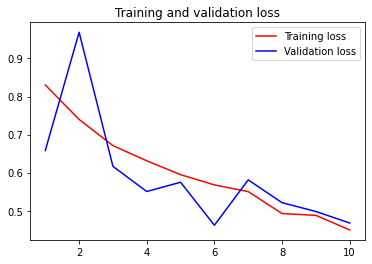

In [76]:
plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
plt.show()

## Model 6: 7 Layer CNN with Average Pooling

In [77]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=tensorflow.keras.optimizers.Adam(),metrics=['acc'])

In [78]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization_47 (Bat  (None, 222, 222, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_40 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 batch_normalization_48 (Bat  (None, 220, 220, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_41 (Conv2D)          (None, 218, 218, 64)      36928     
                                                                 
 average_pooling2d_8 (Averag  (None, 109, 109, 64)    

In [79]:
history = model.fit(x_train, y_train, batch_size=10, epochs=10, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
140/140 [==============================] - 32s 217ms/step - loss: 0.8849 - acc: 0.5821 - val_loss: 0.6460 - val_acc: 0.6100
Epoch 2/10
140/140 [==============================] - 29s 210ms/step - loss: 0.7775 - acc: 0.5721 - val_loss: 0.8572 - val_acc: 0.5000
Epoch 3/10
140/140 [==============================] - 29s 209ms/step - loss: 0.7546 - acc: 0.6071 - val_loss: 0.5779 - val_acc: 0.6800
Epoch 4/10
140/140 [==============================] - 29s 209ms/step - loss: 0.6924 - acc: 0.6329 - val_loss: 0.6123 - val_acc: 0.7000
Epoch 5/10
140/140 [==============================] - 29s 210ms/step - loss: 0.6671 - acc: 0.6264 - val_loss: 0.5808 - val_acc: 0.6800
Epoch 6/10
140/140 [==============================] - 29s 209ms/step - loss: 0.6373 - acc: 0.6664 - val_loss: 0.6203 - val_acc: 0.6100
Epoch 7/10
140/140 [==============================] - 29s 209ms/step - loss: 0.5927 - acc: 0.7029 - val_loss: 0.6115 - val_acc: 0.6800
Epoch 8/10
140/140 [==============================] - 2

In [80]:
acc = history.history['acc']
val_acc =history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

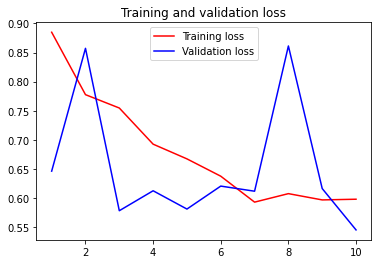

In [81]:
plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
plt.show()